In [7]:
from models.external.NAFNet.NAFNet_arch import NAFNet
import torch
from models.freezed_varnet_nafnet import FreezedVarNetNAFNet
from dataset import SliceGrappaDataModule
import matplotlib.pyplot as plt
import numpy as np
varnet_path = "checkpoints/VarNetLogisticUnetSensFix.pt"

In [2]:
dm = SliceGrappaDataModule(root="/home/Data")
dm.setup('train')
train_loader = dm.train_dataloader()

In [3]:
mask, masked_kspace, grappa, target, maximum, fname, sl = next(iter(train_loader))
mask.shape, masked_kspace.shape, grappa.shape, target.shape, maximum.shape, fname, sl

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-xxizjgd1'


(torch.Size([1, 1, 1, 396, 1]),
 torch.Size([1, 16, 768, 396, 2]),
 torch.Size([1, 384, 384]),
 torch.Size([1, 384, 384]),
 torch.Size([1]),
 ('brain_acc8_76.h5',),
 tensor([6]))

In [4]:
varnet = torch.load(varnet_path).to("cuda")
nafnet = NAFNet()

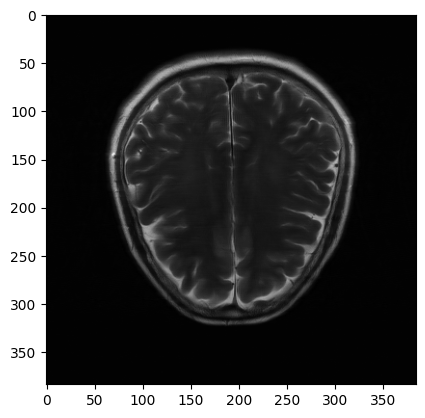

In [5]:
with torch.no_grad():
    masked_kspace = masked_kspace.cuda()
    mask = mask.cuda()
    varnet_result = varnet(masked_kspace, mask)
    varnet_result = FreezedVarNetNAFNet.image_space_crop(varnet_result)
    plt.imshow(varnet_result[0].detach().cpu().numpy(), cmap='gray')

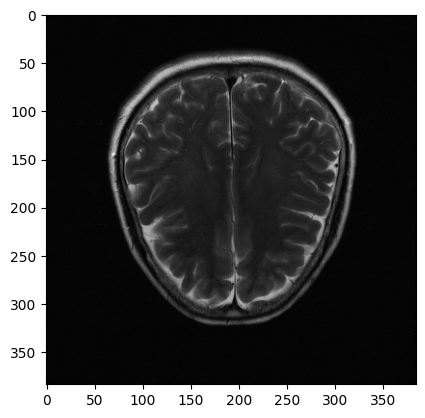

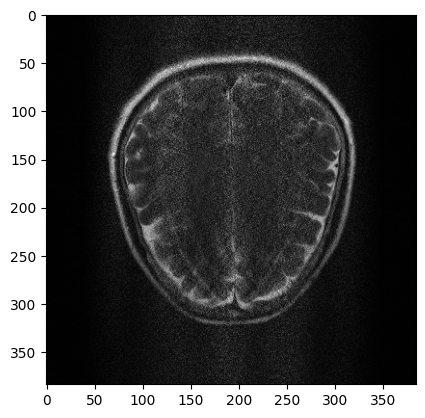

In [6]:
plt.imshow(target[0], cmap='gray')
plt.show()
plt.imshow(grappa[0], cmap='gray')

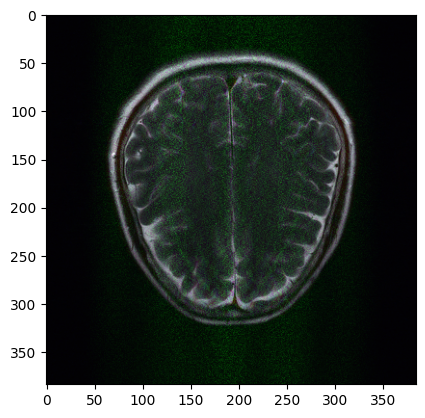

In [12]:
varnet_result_numpy = varnet_result[0].detach().cpu().numpy()
target_numpy = target[0]

bgr_image = np.zeros((varnet_result_numpy.shape[0], varnet_result_numpy.shape[1], 3), dtype=np.uint8)
bgr_image[:,:,0] = (varnet_result_numpy - varnet_result_numpy.min()) / (varnet_result_numpy.max() - varnet_result_numpy.min()) * 255
bgr_image[:,:,1] = (grappa[0] - grappa[0].min()) / (grappa[0].max() - grappa[0].min()) * 255
bgr_image[:,:,2] = (target_numpy - target_numpy.min()) / (target_numpy.max() - target_numpy.min()) * 255

plt.imshow(bgr_image)

In [7]:
nafnet = NAFNet(img_channel=2, width=64, enc_blk_nums=[2, 2, 4, 8], middle_blk_num=12, dec_blk_nums=[2, 2, 2, 2]).cuda()

In [8]:
grappa = grappa.cuda()
result = nafnet(torch.stack([varnet_result, grappa], dim=1))

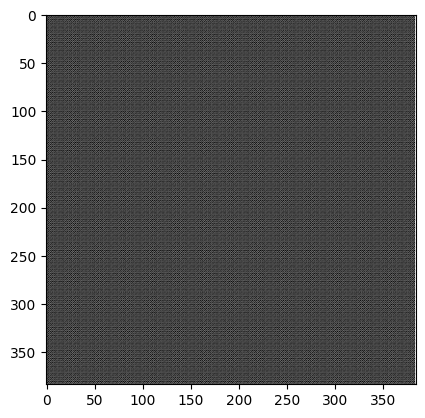

In [12]:
plt.imshow(result[0, 0].detach().cpu().numpy(), cmap='gray')